# Language Translator

In [276]:
import nltk
import pandas as pd
import numpy as np

import string
import re
from numpy import array, argmax, random, take
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import plot_model

In [277]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')

    # read all text
    text = file.read()
    file.close()
    return text

In [278]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [279]:
data = read_text("fra.txt")
fra_eng = to_lines(data)
fra_eng = array(fra_eng)
fra_eng = fra_eng[:50000,:]
fra_eng

array([['Go.', 'Va !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)'],
       ['Go.', 'Marche.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)'],
       ['Go.', 'Bouge !',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)'],
       ...,
       ['No one wants to fight.', 'Personne ne veut se battre.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2091157 (CK) & #2101587 (sacredceltic)'],
       ['No one wants to speak.', 'Personne ne veut parler.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2091158 (CK) & #2101585 (sacredceltic)'],
       ['No one was helping us.', 'Personne ne nous aidait.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4950734 (CK) & #5899355 (Aiji)']],
      dtype='<U349')

### Create and Pre-Process DataFrame

In [280]:
fra_eng = pd.DataFrame(fra_eng)
fra_eng = fra_eng.drop(2,axis=1)
fra_eng.head()

,0,1
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.


In [290]:
df = fra_eng.copy()

In [291]:
df = df.rename(columns={df.columns[1]: 'Fr'})
df = df.rename(columns={df.columns[0]: 'En'})
df = df.astype(pd.StringDtype())
df.head()

,En,Fr
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.


In [292]:
# Make lowercase
df['Fr'] = df['Fr'].str.lower()
df['En'] = df['En'].str.lower()
df.tail()

,En,Fr
49995,no one seemed to hear.,personne ne semblait entendre.
49996,no one speaks with me.,personne ne me parle.
49997,no one wants to fight.,personne ne veut se battre.
49998,no one wants to speak.,personne ne veut parler.
49999,no one was helping us.,personne ne nous aidait.


In [293]:
# Remove Punctuation
import string
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

df['En'] = df['En'].apply(remove_punctuations)
df['Fr'] = df['Fr'].apply(remove_punctuations)
df.head()

,En,Fr
0,go,va
1,go,marche
2,go,bouge
3,hi,salut
4,hi,salut


In [294]:
#df = df.shift(1)
df2 = pd.DataFrame({"En":['I want a beer'],
                    "Fr":['je veux une bière']})
  
df = df.append(df2, ignore_index=True)
df.tail()

,En,Fr
49996,no one speaks with me,personne ne me parle
49997,no one wants to fight,personne ne veut se battre
49998,no one wants to speak,personne ne veut parler
49999,no one was helping us,personne ne nous aidait
50000,I want a beer,je veux une bière


In [296]:
df.loc[0] = df.loc[50000]
df.head()

,En,Fr
0,I want a beer,je veux une bière
1,go,marche
2,go,bouge
3,hi,salut
4,hi,salut


### Text to Sequence Conversion (converts text to tokens)

Visualise the length of the sentences.

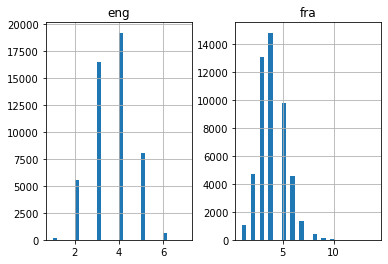

In [297]:
# empty lists
eng_l = []
fra_l = []

# populate the lists with sentence lengths
for i in df['En']:
      eng_l.append(len(i.split()))

for i in df['Fr']:
      fra_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'fra':fra_l})

length_df.hist(bins = 30)
plt.show()

In [298]:
from pickle import load
from pickle import dump
from numpy.random import rand
# reduce dataset size
df = df.head(10000)
# random shuffle
# from numpy.random import shuffle
# shuffle(df)
# split into train/test
train = df.head(8000)
test = df.tail(2000)
# save
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)
    
save_clean_data(df, 'english-french-both_v2.pkl')
save_clean_data(train, 'english-french-train_v2.pkl')
save_clean_data(test, 'english-french-test_v2.pkl')

Saved: english-french-both_v2.pkl
Saved: english-french-train_v2.pkl
Saved: english-french-test_v2.pkl


In [299]:
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

# load datasets
df = load_clean_sentences('english-french-both_v2.pkl')
train = load_clean_sentences('english-french-train_v2.pkl')
test = load_clean_sentences('english-french-test_v2.pkl')

In [302]:
train.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [303]:
df = df[["En", "Fr"]].to_numpy()
train = train[["En", "Fr"]].to_numpy()
test = test[["En", "Fr"]].to_numpy()

<ipython-input-303-8feaddd5a816>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df = df[["En", "Fr"]].to_numpy()


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [304]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [305]:
# prepare English tokenizer
eng_tokenizer = create_tokenizer(df[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(df[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))
# prepare French tokenizer
fra_tokenizer = create_tokenizer(df[:, 1])
fra_vocab_size = len(fra_tokenizer.word_index) + 1
fra_length = max_length(df[:, 1])
print('French Vocabulary Size: %d' % fra_vocab_size)
print('French Max Length: %d' % (fra_length))

English Vocabulary Size: 2027
English Max Length: 5
French Vocabulary Size: 4756
French Max Length: 10


Function to prepare the sequences. It will also perform sequence padding to a maximum sentence length

In [306]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
     # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
     # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### Model Building

Define Seq2Seq model architecture:

* Encoder: use an embedding layer and an LSTM layer
* Decoder: use LSTM layer followed by a dense layer

In [307]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(df, test_size=0.2, random_state = 12)

In [325]:
# prepare training data
trainX = encode_sequences(fra_tokenizer, fra_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(fra_tokenizer, fra_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [326]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(8000, 10)
(8000, 5)
(2000, 10)
(2000, 5)


In [327]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [328]:
# model compilation
model = define_model(fra_vocab_size, eng_vocab_size, fra_length, eng_length, 512)

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 10, 512)           2435072   
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 5, 512)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 512)            2099200   
_________________________________________________________________
dense_3 (Dense)              (None, 5, 2027)           1039851   
Total params: 7,673,323
Trainable params: 7,673,323
Non-trainable params: 0
_________________________________________________________________
None


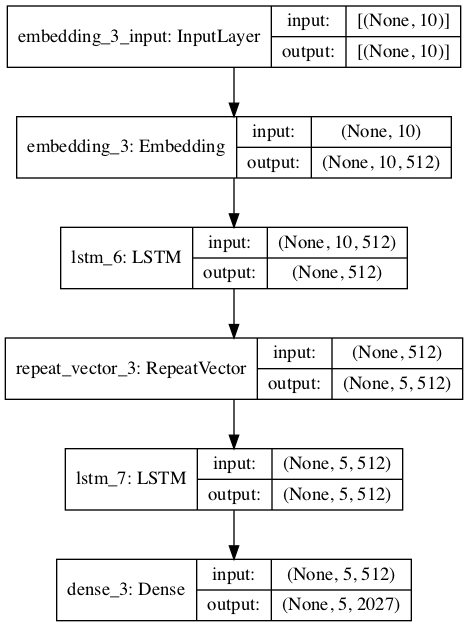

In [329]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
print(model.summary())
plot_model(model, to_file='model_v2.png', show_shapes=True)

### Training the Model

In [119]:
# Epoch 30, batch_size 64

In [330]:
# fit model
filename = 'model_v2.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=5, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/5
13/13 [==============================] - 42s 3s/step - loss: 5.0770 - val_loss: 3.8201

Epoch 00001: val_loss improved from inf to 3.82008, saving model to model_v2.h5
Epoch 2/5
13/13 [==============================] - 28s 2s/step - loss: 3.5951 - val_loss: 3.4364

Epoch 00002: val_loss improved from 3.82008 to 3.43636, saving model to model_v2.h5
Epoch 3/5
13/13 [==============================] - 46s 4s/step - loss: 3.2457 - val_loss: 3.2733

Epoch 00003: val_loss improved from 3.43636 to 3.27329, saving model to model_v2.h5
Epoch 4/5
13/13 [==============================] - 48s 4s/step - loss: 3.1053 - val_loss: 3.1966

Epoch 00004: val_loss improved from 3.27329 to 3.19660, saving model to model_v2.h5
Epoch 5/5
13/13 [==============================] - 53s 4s/step - loss: 3.0263 - val_loss: 3.1996

Epoch 00005: val_loss did not improve from 3.19660


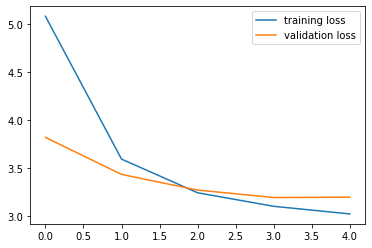

In [331]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.show()

# Evaluate the Model

In [332]:
model = load_model('model_v2.h5')

preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [333]:
preds.shape

(2000, 5)

In [334]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [335]:
preds_text = []
for i in preds:
        temp = []
        for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                    temp.append('')
                else:
                    temp.append(t)
            else:
                    if(t == None):
                        temp.append('')
                    else:
                        temp.append(t) 

        preds_text.append(' '.join(temp))

In [336]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [341]:
# print 10 rows randomly
pred_df.sample(10)

,actual,predicted
1501,terrific,i
820,i can survive,i is
1239,he has a maid,i is
1278,get rid of tom,i
744,theyre awake,i it
1705,theyre new,i it
1509,she is crying,i
791,he has come,i is
1723,isnt it nice,i
39,you must go,i is


In [342]:
pred_df[pred_df.isin(['beer'])]

,actual,predicted
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
1995,NaN,NaN
1996,NaN,NaN
1997,NaN,NaN
1998,NaN,NaN
